In [2]:
%pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn import preprocessing

In [ ]:
import pandas as pd
import os

# Folder dan file output
folder_path = "C:/Users/Eileen/Documents/Skripsi/archive/01-12/"
files = [
    "TFTP.csv", "DrDoS_LDAP.csv", "DrDoS_MSSQL.csv", "DrDoS_NetBIOS.csv",
    "DrDoS_NTP.csv", "DrDoS_SNMP.csv", "DrDoS_SSDP.csv",
    "DrDoS_UDP.csv", "Syn.csv", "DrDoS_DNS.csv", "UDPLag.csv"
]
output_file = "C:/Users/Eileen/Documents/Skripsi/archive/export_dataframe.csv"

# Jika file output sudah ada, hapus agar tidak bentrok
if os.path.exists(output_file):
    os.remove(output_file)

chunk_size = 5000
header_saved = False

for i, file in enumerate(files, start=1):
    file_path = os.path.join(folder_path, file)
    print(f"Processing file {i}/{len(files)}: {file}")

    # Baca file secara bertahap (chunk)
    for chunk in pd.read_csv(file_path, chunksize=chunk_size, low_memory=True):
        # Tulis chunk ke file CSV (append mode)
        if not header_saved:
            # Tulis header pada chunk pertama
            chunk.to_csv(output_file, mode='a', index=False, header=True)
            header_saved = True
        else:
            # Selanjutnya tulis tanpa header
            chunk.to_csv(output_file, mode='a', index=False, header=False)

    print(f"File {file} selesai di-append ke {output_file}")

print("Semua file berhasil digabungkan!")



In [2]:
import pandas as pd
import os

# Folder dan file output
folder_path = "C:/Users/Eileen/Documents/Skripsi/archive/03-11/"
files = ["LDAP.csv", "MSSQL.csv", "NetBIOS.csv", "Portmap.csv", "Syn.csv","UDP.csv","UDPLag.csv"]
output_file = "C:/Users/Eileen/Documents/Skripsi/archive/export_datatest.csv"

# Jika file output sudah ada, hapus agar tidak bentrok
if os.path.exists(output_file):
    os.remove(output_file)

chunk_size = 5000
header_saved = False

for i, file in enumerate(files, start=1):
    file_path = os.path.join(folder_path, file)
    print(f"Processing file {i}/{len(files)}: {file}")

    # Baca file secara bertahap (chunk)
    for chunk in pd.read_csv(file_path, chunksize=chunk_size, low_memory=True):
        # Tulis chunk ke file CSV (append mode)
        if not header_saved:
            # Tulis header pada chunk pertama
            chunk.to_csv(output_file, mode='a', index=False, header=True)
            header_saved = True
        else:
            # Selanjutnya tulis tanpa header
            chunk.to_csv(output_file, mode='a', index=False, header=False)

    print(f"File {file} selesai di-append ke {output_file}")

print("Semua file berhasil digabungkan!")


Processing file 1/7: LDAP.csv
File LDAP.csv selesai di-append ke C:/Users/Eileen/Documents/Skripsi/archive/export_datatest.csv
Processing file 2/7: MSSQL.csv
File MSSQL.csv selesai di-append ke C:/Users/Eileen/Documents/Skripsi/archive/export_datatest.csv
Processing file 3/7: NetBIOS.csv
File NetBIOS.csv selesai di-append ke C:/Users/Eileen/Documents/Skripsi/archive/export_datatest.csv
Processing file 4/7: Portmap.csv
File Portmap.csv selesai di-append ke C:/Users/Eileen/Documents/Skripsi/archive/export_datatest.csv
Processing file 5/7: Syn.csv
File Syn.csv selesai di-append ke C:/Users/Eileen/Documents/Skripsi/archive/export_datatest.csv
Processing file 6/7: UDP.csv
File UDP.csv selesai di-append ke C:/Users/Eileen/Documents/Skripsi/archive/export_datatest.csv
Processing file 7/7: UDPLag.csv
File UDPLag.csv selesai di-append ke C:/Users/Eileen/Documents/Skripsi/archive/export_datatest.csv
Semua file berhasil digabungkan!


In [ ]:
import pandas as pd
import numpy as np
import hashlib
import pyarrow as pa
import pyarrow.parquet as pq

# Path file
csv_path = 'C:/Users/Eileen/Documents/Skripsi/archive/export_dataframe.csv'
parquet_path = 'C:/Users/Eileen/Documents/Skripsi/archive/export_dataframe.parquet'

# Fungsi untuk mengubah string menjadi hash numerik
def string2numeric_hash(text):
    return int(hashlib.md5(text.encode()).hexdigest()[:8], 16)

# Tentukan ukuran chunk (sesuaikan dengan kapasitas memory Anda)
chunksize = 10000

# Baca CSV secara bertahap (chunking)
chunk_iter = pd.read_csv(csv_path, sep=',', chunksize=chunksize, low_memory=False)

# Inisialisasi writer sebagai None
writer = None

for chunk in chunk_iter:
    # Hilangkan spasi ekstra pada nama kolom
    chunk.columns = chunk.columns.str.strip()
    
    # Ganti nilai 'Infinity' dan np.inf dengan 0
    chunk = chunk.replace(['Infinity', np.inf], 0)

    # Konversi kolom numerik dengan aman
    if 'Flow Packets/s' in chunk.columns:
        chunk['Flow Packets/s'] = pd.to_numeric(chunk['Flow Packets/s'], errors='coerce').fillna(0)
    if 'Flow Bytes/s' in chunk.columns:
        chunk['Flow Bytes/s'] = pd.to_numeric(chunk['Flow Bytes/s'], errors='coerce').fillna(0)

    # Konversi label menjadi numerik
    if 'Label' in chunk.columns:
        chunk['Label'] = chunk['Label'].replace({
            'BENIGN': 0, 'DrDoS_DNS': 1, 'DrDoS_LDAP': 1, 'DrDoS_MSSQL': 1,
            'DrDoS_NTP': 1, 'DrDoS_NetBIOS': 1, 'DrDoS_SNMP': 1, 'DrDoS_SSDP': 1,
            'DrDoS_UDP': 1, 'Syn': 1, 'TFTP': 1, 'UDP-lag': 1, 'WebDDoS': 1
        }).astype(int)

    # Pastikan kolom Timestamp tidak memiliki nilai NaN, lalu proses
    if 'Timestamp' in chunk.columns:
        chunk['Timestamp'] = chunk['Timestamp'].fillna('1970-01-01 00:00:00.000000')
        # Pisahkan tanggal dan waktu
        time_parts = chunk['Timestamp'].str.split(' ', n=1, expand=True)
        if time_parts.shape[1] == 2:
            time_parts.columns = ['date', 'time']
            # Pisahkan waktu dari milidetik (jika ada)
            time_split = time_parts['time'].str.split('.', n=1, expand=True)
            if time_split.shape[1] == 2:
                time_split.columns = ['time', 'millisec']
                chunk['Timestamp'] = time_split['time'].apply(string2numeric_hash)
            else:
                chunk['Timestamp'] = chunk['Timestamp'].apply(string2numeric_hash)
        else:
            chunk['Timestamp'] = chunk['Timestamp'].apply(string2numeric_hash)

    # Hapus kolom-kolom yang tidak diperlukan
    cols_to_drop = ['Source IP', 'Destination IP', 'Flow ID', 'SimillarHTTP', 'Unnamed: 0']
    chunk.drop(columns=[col for col in cols_to_drop if col in chunk.columns], inplace=True)

    # Konversi chunk ke table pyarrow
    table = pa.Table.from_pandas(chunk)

    # Jika writer belum dibuat, buat dengan schema table saat ini
    if writer is None:
        writer = pq.ParquetWriter(parquet_path, table.schema)
    
    writer.write_table(table)

# Tutup writer setelah semua chunk selesai diproses
if writer is not None:
    writer.close()

print('Training data processed successfully!')

In [ ]:
import pandas as pd
import numpy as np
import hashlib
import pyarrow as pa
import pyarrow.parquet as pq

# Path file
csv_path = 'C:/Users/Eileen/Documents/Skripsi/archive/export_datatest.csv'
parquet_path = 'C:/Users/Eileen/Documents/Skripsi/archive/export_datatest.parquet'

# Fungsi untuk mengubah string menjadi hash numerik
def string2numeric_hash(text):
    return int(hashlib.md5(text.encode()).hexdigest()[:8], 16)

# Tentukan ukuran chunk (sesuaikan dengan kapasitas memory Anda)
chunksize = 10000

# Baca CSV secara bertahap (chunking)
chunk_iter = pd.read_csv(csv_path, sep=',', chunksize=chunksize, low_memory=False)

# Inisialisasi writer sebagai None
writer = None

for chunk in chunk_iter:
    # Hilangkan spasi ekstra pada nama kolom
    chunk.columns = chunk.columns.str.strip()
    
    # Ganti nilai 'Infinity' dan np.inf dengan 0
    chunk = chunk.replace(['Infinity', np.inf], 0)

    # Konversi kolom numerik dengan aman
    if 'Flow Packets/s' in chunk.columns:
        chunk['Flow Packets/s'] = pd.to_numeric(chunk['Flow Packets/s'], errors='coerce').fillna(0)
    if 'Flow Bytes/s' in chunk.columns:
        chunk['Flow Bytes/s'] = pd.to_numeric(chunk['Flow Bytes/s'], errors='coerce').fillna(0)

    # Konversi label menjadi numerik
    if 'Label' in chunk.columns:
        chunk['Label'] = chunk['Label'].replace({
            'BENIGN': 0, 'LDAP': 1, 'NetBIOS': 1, 'MSSQL': 1,
            'Portmap': 1, 'Syn': 1, 'UDP': 1, 'UDPLag': 1
        }).astype(int)

    # Pastikan kolom Timestamp tidak memiliki nilai NaN, lalu proses
    if 'Timestamp' in chunk.columns:
        chunk['Timestamp'] = chunk['Timestamp'].fillna('1970-01-01 00:00:00.000000')
        # Pisahkan tanggal dan waktu
        time_parts = chunk['Timestamp'].str.split(' ', n=1, expand=True)
        if time_parts.shape[1] == 2:
            time_parts.columns = ['date', 'time']
            # Pisahkan waktu dari milidetik (jika ada)
            time_split = time_parts['time'].str.split('.', n=1, expand=True)
            if time_split.shape[1] == 2:
                time_split.columns = ['time', 'millisec']
                chunk['Timestamp'] = time_split['time'].apply(string2numeric_hash)
            else:
                chunk['Timestamp'] = chunk['Timestamp'].apply(string2numeric_hash)
        else:
            chunk['Timestamp'] = chunk['Timestamp'].apply(string2numeric_hash)

    # Hapus kolom-kolom yang tidak diperlukan
    cols_to_drop = ['Source IP', 'Destination IP', 'Flow ID', 'SimillarHTTP', 'Unnamed: 0']
    chunk.drop(columns=[col for col in cols_to_drop if col in chunk.columns], inplace=True)

    # Konversi chunk ke table pyarrow
    table = pa.Table.from_pandas(chunk)

    # Jika writer belum dibuat, buat dengan schema table saat ini
    if writer is None:
        writer = pq.ParquetWriter(parquet_path, table.schema)
    
    writer.write_table(table)

# Tutup writer setelah semua chunk selesai diproses
if writer is not None:
    writer.close()

print('Test data processed successfully!')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import pyarrow as pa
import pyarrow.parquet as pq

# Parameter downsampling
mult = 5

# Path file
processed_parquet_path = 'C:/Users/Eileen/Documents/Skripsi/archive/export_dataframe.parquet'
final_parquet_path = 'C:/Users/Eileen/Documents/Skripsi/archive/final_downsampled.parquet'

# Inisialisasi list untuk menyimpan data tiap chunk
benign_list = []
anomalous_list = []

# Membaca file Parquet yang sudah diproses secara chunk
pf = pq.ParquetFile(processed_parquet_path)
batch_size = 500000  # Atur sesuai kapasitas memori Anda

for batch in pf.iter_batches(batch_size=batch_size):
    df_chunk = batch.to_pandas()
    # Asumsikan kolom 'Label' sudah berupa numerik: 0 = BENIGN
    benign_chunk = df_chunk[df_chunk['Label'] == 0]
    anomalous_chunk = df_chunk[df_chunk['Label'] != 0]
    
    benign_list.append(benign_chunk)
    anomalous_list.append(anomalous_chunk)

# Gabungkan seluruh chunk untuk masing-masing kategori
benign_df = pd.concat(benign_list, ignore_index=True)
anomalous_df = pd.concat(anomalous_list, ignore_index=True)

print("Total benign flows:", len(benign_df))
print("Total anomalous flows:", len(anomalous_df))

# Tentukan target jumlah anomalous flows (mult kali jumlah benign flows)
target_anomalous = len(benign_df) * mult

# Lakukan downsampling jika jumlah anomalous lebih besar dari target
if len(anomalous_df) > target_anomalous:
    anomalous_df = resample(
        anomalous_df,
        replace=False,
        n_samples=target_anomalous,
        random_state=27
    )

# Gabungkan kembali data benign dan anomalous yang telah diproses
final_df = pd.concat([benign_df, anomalous_df], ignore_index=True)
final_df = final_df.sample(frac=1, random_state=27).reset_index(drop=True)  # Acak data

# Simpan data akhir ke file Parquet
table = pa.Table.from_pandas(final_df)
pq.write_table(table, final_parquet_path)

print("Final downsampled data is done")

Total benign flows: 56863
Total anomalous flows: 50006249
Final downsampled data is done


In [1]:
def train_test(samples):
    # Import `train_test_split` from `sklearn.model_selection`
    from sklearn.model_selection import train_test_split
    import numpy as np
    
    # Specify the data 
    X=samples.iloc[:,0:(samples.shape[1]-1)]
    
    # Specify the target labels and flatten the array
    y= samples.iloc[:,-1]
    
    # Split the data up in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [2]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

file_path = 'C:/Users/Eileen/Documents/Skripsi/End/archive/final_downsampled.parquet'
samples = pd.read_parquet(file_path)

# Split data menjadi fitur (X) dan label (y)
X = samples.drop(columns=["Label"])  # Pastikan nama kolom 'Label' sesuai dataset
y = samples["Label"]

# Pisahkan menjadi train dan test dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Gabungkan kembali untuk upsampling
train_data = pd.concat([X_train, y_train], axis=1)

# Pisahkan kelas minoritas (Normal) dan mayoritas (DDoS)
normal = train_data[train_data["Label"] == 0]
ddos = train_data[train_data["Label"] != 0]

# Lakukan upsampling pada data normal agar seimbang dengan DDoS
normal_upsampled = resample(normal,
                            replace=True,
                            n_samples=len(ddos), 
                            random_state=27)

# Gabungkan kembali dataset setelah upsampling
upsampled_train = pd.concat([normal_upsampled, ddos])

# Pisahkan kembali fitur (X_train) dan label (y_train)
X_train = upsampled_train.drop(columns=["Label"])
y_train = upsampled_train["Label"]

X_train_rf = X_train
y_train_rf = y_train
# Tentukan ukuran input untuk model
input_size = (X_train.shape[1], 1)

# Bersihkan variabel yang tidak diperlukan
del train_data, normal_upsampled, ddos, upsampled_train, normal


In [3]:
def normalize_data(X_train,X_test):
    # Import `StandardScaler` from `sklearn.preprocessing`
    from sklearn.preprocessing import StandardScaler,MinMaxScaler
    
    # Define the scaler 
    #scaler = StandardScaler().fit(X_train)
    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
    
    # Scale the train set
    X_train = scaler.transform(X_train)
    
    # Scale the test set
    X_test = scaler.transform(X_test)
    
    return X_train, X_test

In [4]:
import pandas as pd

# Baca file Parquet sebagai data uji
file_path = 'C:/Users/Eileen/Documents/Skripsi/End/archive/export_datatest.parquet'
tests = pd.read_parquet(file_path)

# Pisahkan fitur (X_test) dan label (y_test) 
X_test = tests.iloc[:, 0:(tests.shape[1] - 1)]  
y_test = tests.iloc[:, -1]

# Normalisasi data train dan test
X_train, X_test = normalize_data(X_train, X_test)

In [5]:
#Reshape data in 3d or 2d format for input in methods CNN)
def format_3d(df):
    
    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

def format_2d(df):
    
    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1]))

In [7]:
def compile_train(model, X_train, y_train, deep=True):
    
    if(deep==True):
        import matplotlib.pyplot as plt

        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        
        history = model.fit(X_train, y_train, epochs=10, batch_size=256, verbose=1)

        # summarize history for accuracy
        plt.plot(history.history['accuracy']) 
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper left')
        plt.show()

        print(model.metrics_names)
    
    else:
        model.fit(X_train, y_train)  # For SVM
    
    print('Model Compiled and Trained')
    return model

In [8]:
def testes(model,X_test,y_test,y_pred, deep=True):
    if(deep==True): 
        score = model.evaluate(X_test, y_test,verbose=1)

        print(score)

    # Import the modules from `sklearn.metrics`
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
    
    # Accuracy 
    acc = accuracy_score(y_test, y_pred)
    print('\nAccuracy')
    print(acc)
    
    # Precision 
    prec = precision_score(y_test, y_pred)
    print('\nPrecision')
    print(prec)
    
    # Recall
    rec = recall_score(y_test, y_pred)
    print('\nRecall')
    print(rec)
    
    # F1 score
    f1 = f1_score(y_test,y_pred) #,average='macro')
    print('\nF1 Score')
    print(f1)
    
    # Average
    avrg = (acc+prec+rec+f1)/4
    print('\nAverage (acc, prec, rec, f1)')
    print(avrg)
    
    return acc, prec, rec, f1, avrg

In [9]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv1D,MaxPooling1D

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense

def CNN_model(input_size):
    model = Sequential([
        Input(shape=(input_size, 1)),  
        Conv1D(filters=64, kernel_size=8, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=32, kernel_size=16, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=16, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        Dropout(0.5),
        
        Flatten(),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid') 
    ])  
    
    model.summary() 
    
    return model 


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 75, 64)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 37, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 32)         │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 9, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,589 (139.02 KB)

 Trainable params: 35,589 (139.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9677 - loss: 0.0902
Epoch 2/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9976 - loss: 0.0103
Epoch 3/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9982 - loss: 0.0074
Epoch 4/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9986 - loss: 0.0058
Epoch 5/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9986 - loss: 0.0056
Epoch 6/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9988 - loss: 0.0046
Epoch 7/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9989 - loss: 0.0045
Epoch 8/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9989 - loss: 0.0045
Epoch 9/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9990 - loss: 0.0039
Epoch 10/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9990 - loss: 0.0040


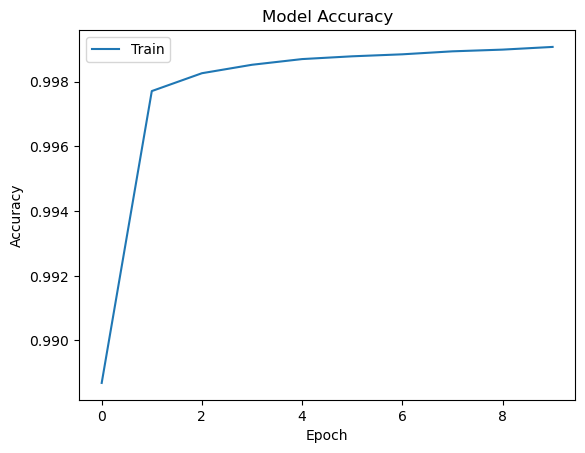

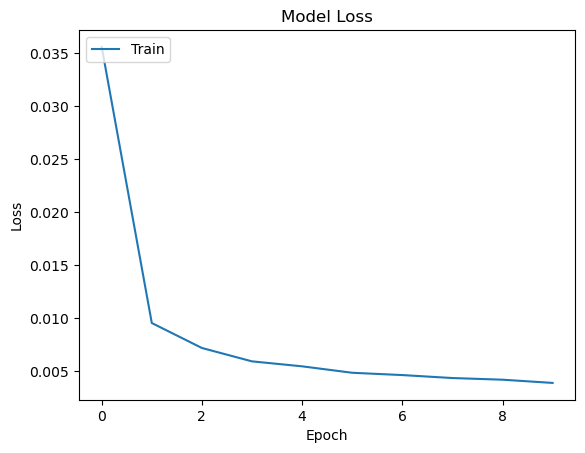

['loss', 'compile_metrics']
Model Compiled and Trained


In [11]:
model_cnn = CNN_model(X_train.shape[1])
model_cnn = compile_train(model_cnn,format_3d(X_train),y_train)

In [ ]:
y_pred = model_cnn.predict(format_3d(X_test))

y_pred = y_pred.round()

acc, prec, rec, f1, avrg = testes(model_cnn, format_3d(X_test), y_test, y_pred)

636392/636392 ━━━━━━━━━━━━━━━━━━━━ 1651s 3ms/step
636392/636392 ━━━━━━━━━━━━━━━━━━━━ 13192s 21ms/step - accuracy: 0.9995 - loss: 0.0020
[0.0034837289713323116, 0.9991104006767273]

Accuracy
0.9990649425901169

Precision
0.9999955640327437

Recall
0.9990667514955022

F1 Score
0.9995309419897765

Average (acc, prec, rec, f1)
0.9994145500270348


NameError: name 'test_normal_atk' is not defined

In [16]:
from sklearn.svm import LinearSVC

In [17]:
model_svm = LinearSVC()
model_svm = compile_train(model_svm,X_train,y_train,False)

Model Compiled and Trained


In [ ]:
y_pred = model_svm.predict(X_test)

y_pred = y_pred.round()

acc, prec, rec, f1, avrg = testes(model_svm, X_test, y_test, y_pred, False)


Accuracy
0.9996296991950463

Precision
0.9999913794670432

Recall
0.9996372779398411

F1 Score
0.999814297350648

Average (acc, prec, rec, f1)
0.9997681634881447


C:\Users\Eileen\AppData\Local\Temp\ipykernel_18548\229298339.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
C:\Users\Eileen\AppData\Local\Temp\ipykernel_18548\229298339.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk


In [ ]:
#random forest 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import RandomForestClassifier
# RF with 100 decision-trees

rfc = RandomForestClassifier(random_state=0)

# fit the model
rfc.fit(X_train_rf, y_train_rf)

# Predict the Test set results
y_pred = rfc.predict(X_test)

In [9]:
acc, prec, rec, f1, avrg = testes(rfc, X_test, y_test, y_pred, False)


Accuracy
0.9999120698751393

Precision
1.0

Recall
0.9998944832316269

F1 Score
0.9999472388322195

Average (acc, prec, rec, f1)
0.9999384479847464


c:\Users\Eileen\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.9859 - loss: 0.0408
Epoch 2/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.9990 - loss: 0.0040
Epoch 3/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9992 - loss: 0.0033
Epoch 4/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9993 - loss: 0.0028
Epoch 5/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9994 - loss: 0.0024
Epoch 6/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9994 - loss: 0.0021
Epoch 7/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.9994 - loss: 0.0021
Epoch 8/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9995 - loss: 0.0019
Epoch 9/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9996 - loss: 0.0016
Epoch 10/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9996 - loss: 0.0014


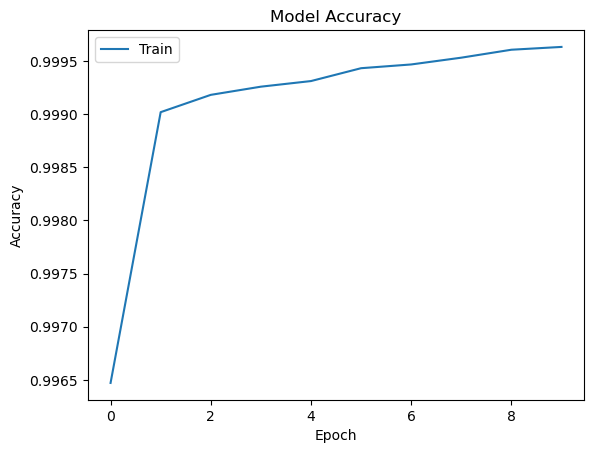

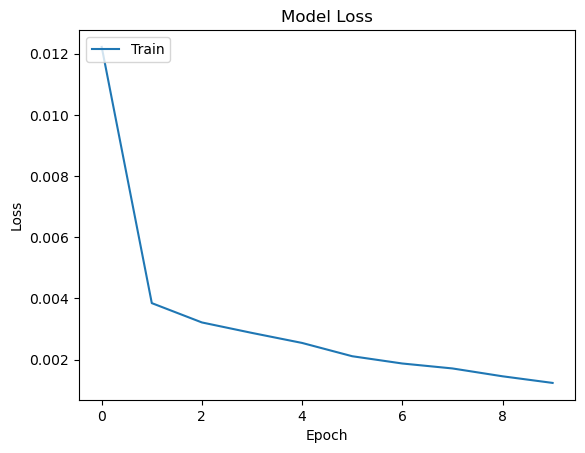

['loss', 'compile_metrics']
Model Compiled and Trained
636392/636392 ━━━━━━━━━━━━━━━━━━━━ 1315s 2ms/step
Ensemble Model Accuracy: 0.9999256550300093
Precision: 0.9999872455034736
Recall: 0.9999382003549417
F1 Score: 0.9999627223278286


In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Format data for CNN (3D input)
X_train_cnn = format_3d(X_train)
X_test_cnn = format_3d(X_test)

# CNN Model
def build_cnn_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Binary classification
    return model

# CNN Model Training
cnn_model = build_cnn_model((X_train_cnn.shape[1], 1))
cnn_model = compile_train(cnn_model, X_train_cnn, y_train)

# Train Random Forest Model
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)

# Train SVM Model
svm_model = LinearSVC(random_state=0)
svm_model.fit(X_train, y_train)

# Get predictions from all models
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype(int)
y_pred_svm = svm_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Stack the predictions to create new feature set for the meta-model
stacked_predictions = np.column_stack((y_pred_cnn, y_pred_svm, y_pred_rf))

# Train a meta-model (Logistic Regression)
meta_model = LogisticRegression(random_state=0)
meta_model.fit(stacked_predictions, y_test)

# Make final predictions using the meta-model
final_predictions = meta_model.predict(stacked_predictions)

# Evaluate the model
acc = accuracy_score(y_test, final_predictions)
print(f"Ensemble Model Accuracy: {acc}")

# Optionally, evaluate other metrics (precision, recall, f1-score)
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
